<a href="https://colab.research.google.com/github/MoritzHaw/BPI2019_Colabatory/blob/main/HandleData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install pm4py

In [ ]:
import pm4py
import pandas as pd
import numpy as np

In [ ]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

log_csv = pd.read_csv('http://icpmconference.org/2019/wp-content/uploads/sites/6/2019/02/BPIChallenge2019CSV.zip', encoding='cp1252',sep=',')
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

In [ ]:
log_csv.rename(columns={'eventID':'eventID', 'case Spend area text': 'case:spend:area', 'case Company': 'case:company', 'case Document Type':'case:doc:type',\
                        'case Sub spend area text': 'case:spend:area:text','case Purchasing Document':'case:doc:id',\
                        'case Purch. Doc. Category name':'case:purch:category', 'case Vendor':'case:vendor', 'case Item Type': 'case:item:type',\
                        'case Item Category': 'case:item:category', 'case Spend classification text':'case:purch:class',	'case Source': 'case:source',\
                        'case Name':'case:vendor:name', 'case GR-Based Inv. Verif.': 'case:invoicing:required', 'case Item': 'case:item',\
                        'case concept:name': 'case:concept:name', 'case Goods Receipt': 'case:goods:receipt', 'event User': 'event:user',\
                        'event org:resource': 'org:resource', 'event concept:name': 'concept:name', 'event Cumulative net worth (EUR)': 'cumulative:net:worth:EUR',\
                        'event time:timestamp': 'time:timestamp'}, inplace=True)

In [ ]:
log_csv['case:concept:name'].count()

1595923

In [ ]:
def to_eventlog(dataset):
  # Convert log_csv to event_log
  parameters = {log_converter.Variants.TO_EVENT_LOG.value.Parameters.CASE_ID_KEY: 'case:concept:name'}  # identify the case_id_key name (if not change it will simply be the nane of the coloumn)
  event_log = log_converter.apply(dataset, parameters=parameters, variant=log_converter.Variants.TO_EVENT_LOG)
  return event_log

In [ ]:
event_log = to_eventlog(log_csv)

In [ ]:
# calculate percentage of cases which werent in 2018

date_percentage = log_csv[log_csv['time:timestamp'].between('2018-01-01 00:00:00', '2018-12-31 23:59:00')].count()
percentage = 100 - (date_percentage['case:concept:name']/log_csv['case:concept:name'].count()) * 100
print(percentage)
#log_csv.groupby['case:concept:name']('time:timestamp').between('2018-01-01 00:00:00', '2018-12-31 23:59:00').count()

2.8481950570296846


In [ ]:
from pm4py.algo.filtering.log.timestamp import timestamp_filter # filter between dates
 
def filter_by_period(dataset, eventlog, date1: str, date2: str):
        '''
        :param dataset: dataset, which should be filtered
        :param date1: startdate
        :param date2: enddate
        :return: filtered eventlog
        '''
        filtered_log = timestamp_filter.filter_traces_contained(eventlog, date1, date2)
        df_filtered_by_period = log_converter.apply(
            filtered_log, variant=log_converter.Variants.TO_DATA_FRAME)
        return df_filtered_by_period, filtered_log

log_filtered_byDate, event_log_date = filter_by_period(log_csv, event_log, 
                                                       "2018-01-01 00:00:00", 
                                                       "2019-01-28 23:59:00")

In [ ]:
log_date_nunique = log_filtered_byDate.nunique().sort_values(ascending=False)
#log_nunique.to_excel('/content/excel/log_nunique.xlsx')
log_date_nunique
log_filtered_byDate.value_counts('case:item:type')

case:item:type
Standard          1088113
Service            240987
Consignment         34717
Third-party         26014
Subcontracting      20508
Limit                4449
dtype: int64

In [ ]:
# count occurrences of concept:name to analyze which values are important

def count_occurrences(log, column: str):
        """
        :param column: name of the column where the values should be counted
        :return: counted occurences of column values
        """
        count_column = log.groupby(column).count()
        return count_column

# Bar chart to compare filter

In [ ]:
def count_events(dataset):
  return dataset['case:concept:name'].count()

In [ ]:
# decrease percent

def decrease_in_perc(dataset1, dataset2):
  return 1 - count_events(dataset2)/count_events(dataset1)

In [ ]:
# compare before and after filtering date 

import matplotlib.pyplot as plt
import seaborn as sns

def comp_bef_aft(dataset1 , dataset2):

    plt.style.use('ggplot')

    x = ['without filtering', 'after filtering']
    events = [count_events(dataset1), count_events(dataset2)]

    x_pos = [i for i, _ in enumerate(x)]
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    color = sns.color_palette("muted")
    plt.figure(1, figsize=(5, 5))  # size
    plt.bar(x_pos, events, color=color)
    plt.xlabel("Filter")
 
    plt.ylabel("Events")
    #plt.title("Energy output from various fuel sources")
    plt.grid(False)

    plt.xticks(x_pos, x)
    plt.axhline(y=0, color='black')

    plt.show()

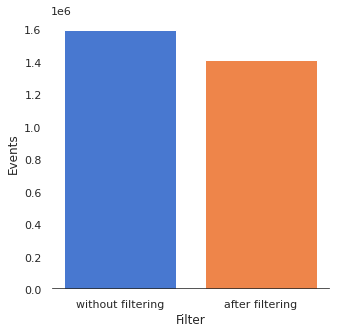

In [ ]:
comp_bef_aft(log_csv, log_filtered_byDate)

# Filtering Data Functions

In [ ]:
#from pm4py.algo.filtering.log.attributes import attributes_filter
from pm4py.algo.filtering.pandas.attributes import attributes_filter

def filter_log_by_cat(log, item_category: str):
    '''
    :log: dataset
    :item_category: e.g. "3-way match, invoice after GR"
    filter data by case item category
    :return: filtered data IVaGR
    '''
    
    df_tracefilter_cat = attributes_filter.apply(
        log, [item_category], parameters={attributes_filter.Parameters.CASE_ID_KEY: 
                                          "case:concept:name",
                                          attributes_filter.Parameters.ATTRIBUTE_KEY: 
                                          "case:item:category", 
                                          attributes_filter.Parameters.POSITIVE: True})

    return df_tracefilter_cat

In [ ]:
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.generic.pandas import case_statistics

def filter_by_variants(dataset):
      variants = case_statistics.get_variants_df(
          dataset, parameters={case_statistics.Parameters.CASE_ID_KEY: 
                               "case:concept:name",
                               case_statistics.Parameters.ACTIVITY_KEY: 
                               "concept:name"})
      return variants

def variants_statistics(dataset):
      variants_count = case_statistics.get_variant_statistics(dataset,
                                          parameters={case_statistics.Parameters.CASE_ID_KEY: "case:concept:name",
                                                      case_statistics.Parameters.ACTIVITY_KEY: "concept:name"})
      return variants_count

In [ ]:
def merge_df(data1, data2, on):
      merge_df = pd.merge(data1, data2, on=on)
      return merge_df

# Filtering IVaGR

In [ ]:
log_filtered_IVaGR = filter_log_by_cat(log_filtered_byDate, "3-way match, invoice after GR")
#log_filtered_IVaGR

In [ ]:
variants_IVaGR = filter_by_variants(log_filtered_IVaGR)
#variants_IVaGR

In [ ]:
variants_contains_GR_IV = variants_IVaGR[
  (variants_IVaGR['variant'].str.contains('Goods Receipt')) & 
  (variants_IVaGR['variant'].str.contains('Invoice Receipt'))]
#variants_contains_GR_IV

In [ ]:
variants_contains_GR_IV['value_GR'] = variants_contains_GR_IV['variant'].str.count(
    'Record Goods Receipt')
variants_contains_GR_IV['value_IV'] = variants_contains_GR_IV['variant'].str.count(
    'Record Invoice Receipt')

variants_contains_GR_IV = variants_contains_GR_IV[variants_contains_GR_IV.value_IV ==
                                                  variants_contains_GR_IV.value_GR]
#variants_contains_GR_IV



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


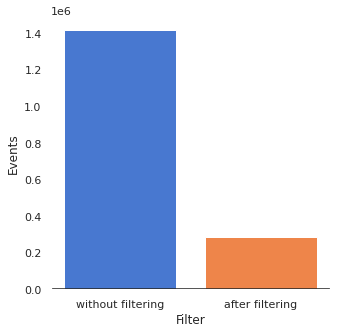

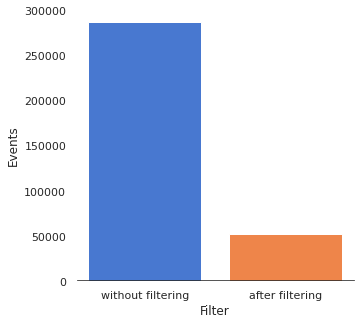

In [ ]:
# merge dataframes
df_IVaGR = merge_df(log_filtered_IVaGR, variants_contains_GR_IV, 'case:concept:name')
#df_IVaGR_containsGR_IV.value_counts('concept:name')

#df_IVaGR_containsGR_IV.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
df_IVaGR.to_pickle('PKL_IVaGR_filtered')
comp_bef_aft(log_filtered_byDate, log_filtered_IVaGR)
comp_bef_aft(log_filtered_IVaGR, df_IVaGR)

In [ ]:
count_events(df_IVaGR)
decrease_in_perc(log_filtered_IVaGR, df_IVaGR)

0.8181967024660092

In [ ]:
#filtered_log = pm4py.filter_variants_top_k(df_IVaGR , 25)
#filtered_log.value_counts('concept:name')

In [ ]:
#filtered_log_2 = variants_filter.filter_variants_variants_percentage(event_log, variants_contains_GR_IV, variants_percentage=0.5)

#filtered_log_2

# Filtering IVbGR

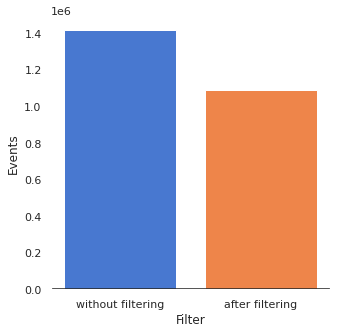

1088559

In [ ]:
log_filtered_IVbGR = filter_log_by_cat(log_filtered_byDate, "3-way match, invoice before GR") 
comp_bef_aft(log_filtered_byDate, log_filtered_IVbGR)
decrease_in_perc(log_filtered_byDate, log_filtered_IVbGR)
count_events(log_filtered_IVbGR)

In [ ]:
variants_IVbGR = filter_by_variants(log_filtered_IVbGR)
#variants_IVbGR

In [ ]:
variants_contains_GR = variants_IVbGR[(variants_IVbGR['variant'].str.contains(
    'Goods Receipt'))]
#variants_contains_GR

In [ ]:
# Value of invoice receipts = value of clear invoice message = value of vendor 
# creates invoice

variants_contains_GR['value_CIV'] = variants_contains_GR['variant'].str.count(
    'Clear Invoice')
variants_contains_GR['value_IV'] = variants_contains_GR['variant'].str.count(
    'Record Invoice Receipt')
variants_contains_GR['value_NIV'] = variants_contains_GR['variant'].str.count(
    'Vendor creates invoice')

#merged_values = pd.merge(variants_value_GR, variants_value_IV, on=['case:concept:name'], how='inner')
#merged_values

#variants_contains_GR_IV.drop(['case:concept:name'])

variants_contains_CIV_IV_NIV = variants_contains_GR[(
    variants_contains_GR.value_CIV == variants_contains_GR.value_IV) & 
    (variants_contains_GR.value_CIV == variants_contains_GR.value_NIV)]
#variants_contains_CIV_IV_NIV


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

In [ ]:
# merge dataframes
df_IVbGR = merge_df(log_filtered_IVbGR, variants_contains_CIV_IV_NIV, 'case:concept:name')
#df_IVbGR

#df_IVbGR.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
df_IVbGR.to_pickle('PKL_IVbGR_filtered')
decrease_in_perc(log_filtered_IVbGR, df_IVbGR)
#comp_bef_aft(log_filtered_IVbGR, df_IVbGR)
count_events(df_IVbGR)

889866

In [ ]:
#df_IVbGR.to_csv('CSV_IVbGR_filtered',  encoding='cp1252',sep=',')

# Filtering nGR

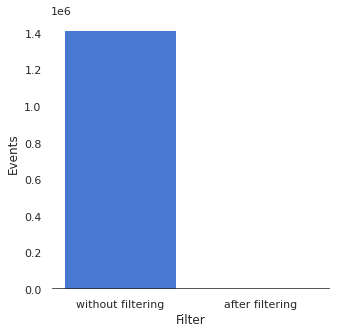

0.99685535924817

In [ ]:
log_filtered_nGR = filter_log_by_cat(log_filtered_byDate, "2-way match")
comp_bef_aft(log_filtered_byDate, log_filtered_nGR) 
count_events(log_filtered_nGR)
decrease_in_perc(log_filtered_byDate, log_filtered_nGR)

In [ ]:
variants_nGR = filter_by_variants(log_filtered_nGR)
#variants_nGR

In [ ]:
variants_contains_IV = variants_nGR[(variants_nGR['variant'].str.contains(
    'Invoice Receipt'))]
#variants_contains_IV

In [ ]:
variants_contains_IV['value_IV'] = variants_contains_IV['variant'].str.count(
    'Record Invoice Receipt')
variants_contains_IV['value_NIV'] = variants_contains_IV['variant'].str.count(
    'Vendor creates invoice')

#merged_values = pd.merge(variants_value_GR, variants_value_IV, on=['case:concept:name'], how='inner')
#merged_values

#variants_contains_GR_IV.drop(['case:concept:name'])

variants_contains_IV_NIV = variants_contains_IV[variants_contains_IV.value_IV == 
                                                variants_contains_IV.value_NIV]
#variants_contains_IV_NIV

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


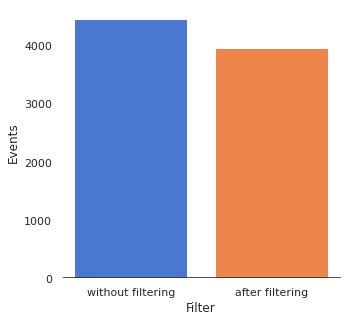

In [ ]:
df_nGR = merge_df(log_filtered_nGR, variants_contains_IV_NIV, 'case:concept:name')

df_nGR.to_pickle('PKL_nGR_filtered')
#df_nGR.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
decrease_in_perc(log_filtered_nGR, df_nGR)
comp_bef_aft(log_filtered_nGR, df_nGR)
#count_events(df_nGR)

In [ ]:
#df_nGR_containsIV.to_csv('CSV_nGR_filtered',  encoding='cp1252',sep=',')

# Filtering Con

In [ ]:
log_filtered_Con = filter_log_by_cat(log_filtered_byDate, "Consignment")
#log_filtered_Con

#count_events(log_filtered_Con)
#decrease_in_perc(log_filtered_byDate, log_filtered_Con)
#comp_bef_aft(log_filtered_byDate, log_filtered_Con)

In [ ]:
variants_Con = filter_by_variants(log_filtered_Con)
#variants_Con

In [ ]:
# check if GR > 0 and IV = 0

variants_contains_GR = variants_Con[
  (variants_Con['variant'].str.contains('Goods Receipt')) & 
  (variants_Con['variant'].str.contains('Invoice') == False)]
#variants_contains_GR

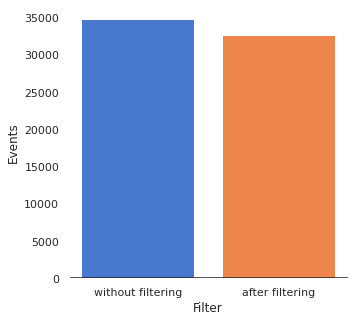

In [ ]:
# merge 
df_Con = merge_df(log_filtered_Con, variants_contains_GR, 'case:concept:name')

df_Con.to_pickle('PKL_Con_filtered')
#df_Con.to_csv('CSV_IVaGR_filtered',  encoding='cp1252',sep=',')
decrease_in_perc(log_filtered_Con, df_Con)
comp_bef_aft(log_filtered_Con, df_Con)
#count_events(df_Con)

In [ ]:
#df_Con.to_csv('CSV_Con_filtered',  encoding='cp1252',sep=',')

# Check on most frequent variants of the whole data

---



In [ ]:
# Pareto principle
from pm4py.algo.filtering.log.variants import variants_filter

def filter_pareto(e_log):
   filtered_log = variants_filter.filter_log_variants_percentage(e_log, percentage=0.2)
   return filtered_log

In [ ]:
# count variants 

from pm4py.statistics.traces.generic.log import case_statistics
variants_count = case_statistics.get_variant_statistics(event_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)


In [ ]:
# Transform records (a list of dicts) into a dataframe
# used to convert the variants_count dictionary into a data frame

log_csv_variants = pd.DataFrame.from_records(variants_count)
log_csv_variants['count'].head(5).sum()/log_csv_variants['count'].sum()

0.45103561696076017

Text(0.5, 1.0, 'bar chart of variants frequency')

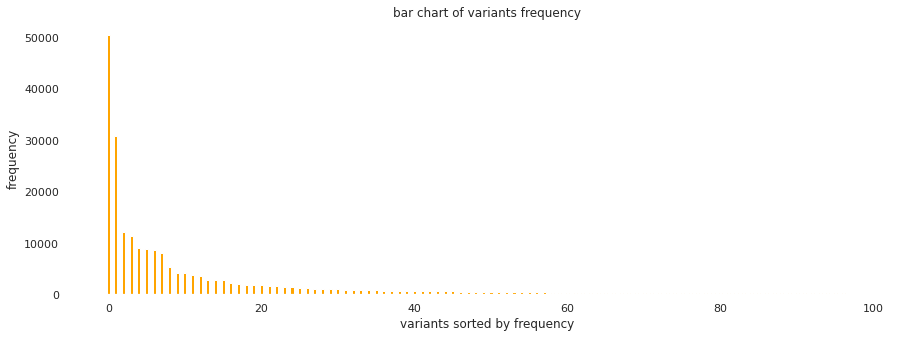

In [ ]:
import math
# Prepare the dimensions to plot
# Put variants and counts into lists of prefered length

variant = log_csv_variants.head(100).index
frequency = log_csv_variants['count'].head(100)
# return a list of log values from a list 
#frequency_log = [math.log(i, 2) for i in frequency] 
#print(frequency)
#print(frequency_log)

# Plot the histogram of the frequencies

fig = plt.figure(figsize = (15, 5))
 
# creating the bar plot
plt.bar(variant, frequency, color ='orange',
        width = 0.4)
 
plt.xlabel("variants sorted by frequency")
plt.ylabel("frequency")
plt.title("bar chart of variants frequency")
#plt.show()

# Convert the string of activites in a variant to a list 
#print(String2List(variants_df['variant'][2],","))